# Interview Analysis Notebook

This notebook is set up to load the provided CSV files and explore them systematically.

In [1]:
# --- Use the Colab button in README.md to run this notebook live in Google Colabs OR Download repo, install requirements and run locally ---
import os, subprocess, sys

REPO   = "monkeymoves/nesta"
BRANCH = "master"
TARGET = "/content/nesta"

IN_COLAB = "google.colab" in sys.modules

def sh(*args): 
    subprocess.run(list(args), check=True)

if IN_COLAB:
    if not os.path.isdir(TARGET):
        sh("git", "clone", "--depth", "1", "--branch", BRANCH, f"https://github.com/{REPO}.git", TARGET)
    else:
        sh("git", "-C", TARGET, "pull", "origin", BRANCH)
    os.chdir(TARGET)

print("CWD:", os.getcwd())

CWD: /Users/lukemaggs/Desktop/Nesta_Interview_LM/notebooks


In [2]:
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_RAW       = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW:", DATA_RAW)

PROJECT_ROOT: /Users/lukemaggs/Desktop/Nesta_Interview_LM
DATA_RAW: /Users/lukemaggs/Desktop/Nesta_Interview_LM/data/raw


In [3]:
import pandas as pd
import numpy as n
import re
import matplotlib.pyplot as plt

FILENAMES = [
    "lfs_monthly_variables.csv",
    "lfs_quarterly_variables.csv",
    "qual_survey_responses.csv",
    "variable_names.csv",
]

# Only the two LFS files need the first 3 rows dropped (CDID/PreUnit/Unit) -# keep header (row 0),
SKIPROWS = {
    "lfs_monthly_variables.csv":    [1, 2, 3],  
    "lfs_quarterly_variables.csv":  [1, 2, 3],
}

def read_csv_safely(path: Path) -> pd.DataFrame:
    """Try a few encodings; keep header row; optionally skip metadata rows."""
    fname = path.name
    kwargs = {}
    if fname in SKIPROWS:
        kwargs["skiprows"] = SKIPROWS[fname]
    for enc in ("utf-8", "utf-8-sig", "cp1252", "latin-1"):
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, encoding="latin-1", encoding_errors="replace", **kwargs)

dfs = {}
for fn in FILENAMES:
    p = DATA_RAW / fn
    df = read_csv_safely(p)
    dfs[fn] = df
    print(f"{fn:>28s}  →  {df.shape}")

   lfs_monthly_variables.csv  →  (385, 1831)
 lfs_quarterly_variables.csv  →  (121, 1831)
   qual_survey_responses.csv  →  (110, 4)
          variable_names.csv  →  (1830, 1)


In [4]:

def parse_period_col(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy with a 'period' index from the first column; drops blanks."""
    df = df.copy()
    time_col = df.columns[0]
    s = df[time_col].astype(str).str.strip()

    def to_timestamp(x: str):
        # Quarter like "1994 Q1"
        m = re.match(r"^\s*(\d{4})\s*Q([1-4])\s*$", x, re.I)
        if m:
            yr, q = int(m.group(1)), int(m.group(2))
            return pd.Period(f"{yr}Q{q}", freq="Q").to_timestamp("Q")
        # Month like "1992 MAR" or "1992 Apr"
        m2 = re.match(r"^\s*(\d{4})\s+([A-Za-z]{3,})\s*$", x)
        if m2:
            dt = pd.to_datetime(f"{m2.group(1)} {m2.group(2)}", errors="coerce", format="%Y %b")
            if pd.notna(dt):
                # coerce to quarter end for consistency
                q = (dt.month - 1)//3 + 1
                return pd.Period(f"{dt.year}Q{q}", freq="Q").to_timestamp("Q")
        try:
            dt = pd.to_datetime(x, errors="raise")
            q = (dt.month - 1)//3 + 1
            return pd.Period(f"{dt.year}Q{q}", freq="Q").to_timestamp("Q")
        except Exception:
            return pd.NaT

    idx = s.apply(to_timestamp)
    out = df[idx.notna()].copy()
    out.index = idx[idx.notna()]
    out = out.drop(columns=[time_col]).sort_index()
    return out

# Apply to the two LFS tables
df_lfs_m = parse_period_col(dfs["lfs_monthly_variables.csv"])
df_lfs_q = parse_period_col(dfs["lfs_quarterly_variables.csv"])

print("lfs_monthly_variables (parsed): ", df_lfs_m.shape, "| index:", df_lfs_m.index.min(), "→", df_lfs_m.index.max())
print("lfs_quarterly_variables (parsed):", df_lfs_q.shape, "| index:", df_lfs_q.index.min(), "→", df_lfs_q.index.max())

lfs_monthly_variables (parsed):  (385, 1830) | index: 1992-03-31 00:00:00 → 2024-03-31 00:00:00
lfs_quarterly_variables (parsed): (121, 1830) | index: 1994-03-31 00:00:00 → 2024-03-31 00:00:00


In [5]:
# Clean & interpolate the quarterly dataset
df_q = df_lfs_q.copy()

# Convert to numeric and NaN out non-numeric
df_q = df_q.apply(pd.to_numeric, errors="coerce")

# Count how much gaps 
na_pct = df_q.isna().mean().sort_values(ascending=False)
print(f"Columns with >50% missing: {(na_pct > 0.5).sum()} / {len(na_pct)}")

# drop extremely sparse series
df_q = df_q.loc[:, na_pct <= 0.5]

# Fill short gaps linearly, but don't extrapolate
df_q = df_q.interpolate(method="linear", limit_direction="forward", axis=0)

# check test
# df_q.iloc[:, :5].head(10)

Columns with >50% missing: 137 / 1830


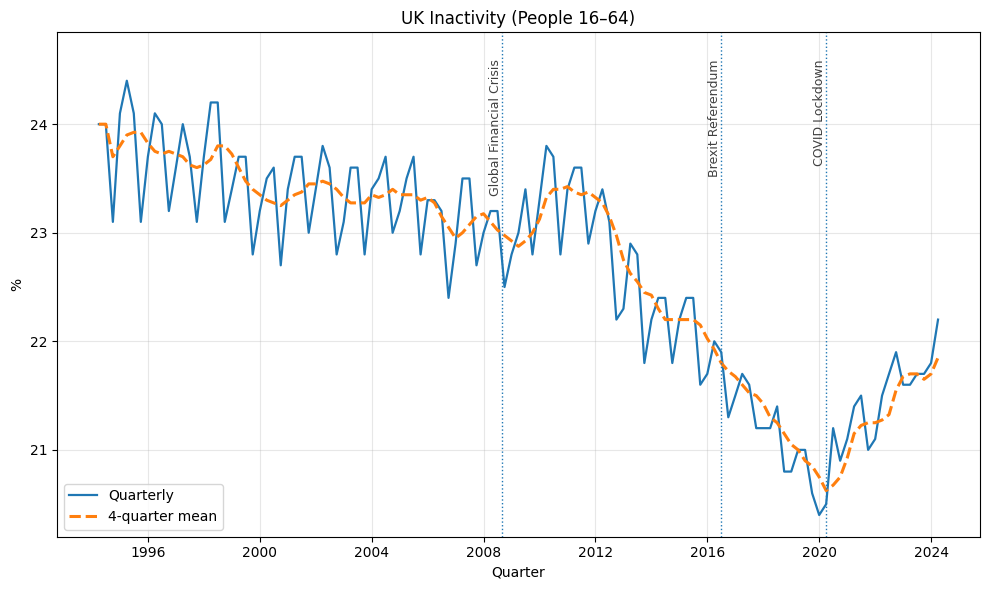

UK Inactivity (People 16–64)
Start: 24.0%  →  End: 22.2%
~YoY change: +0.6%


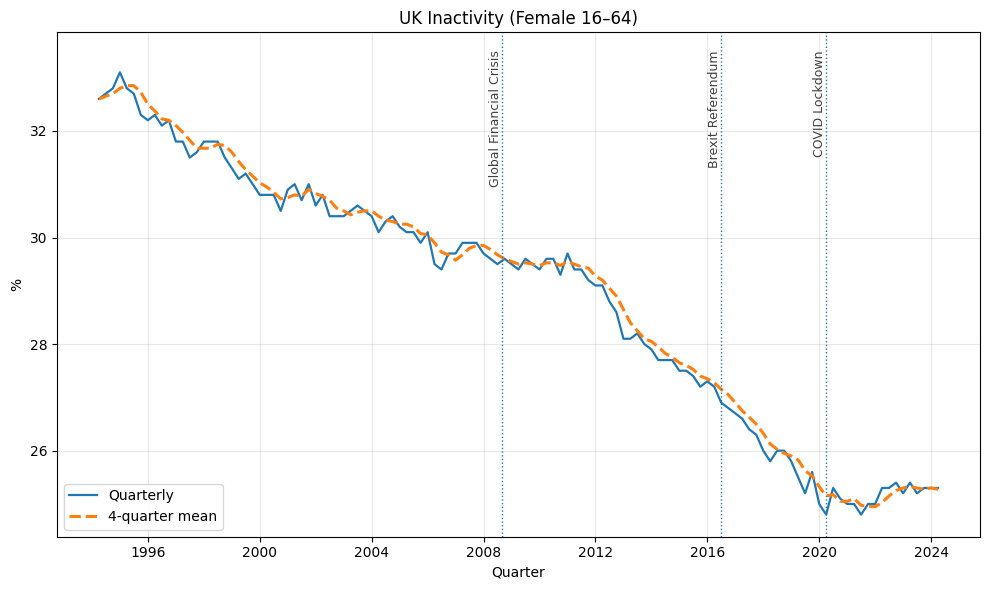

UK Inactivity (Female 16–64)
Start: 32.6%  →  End: 25.3%
~YoY change: -0.1%


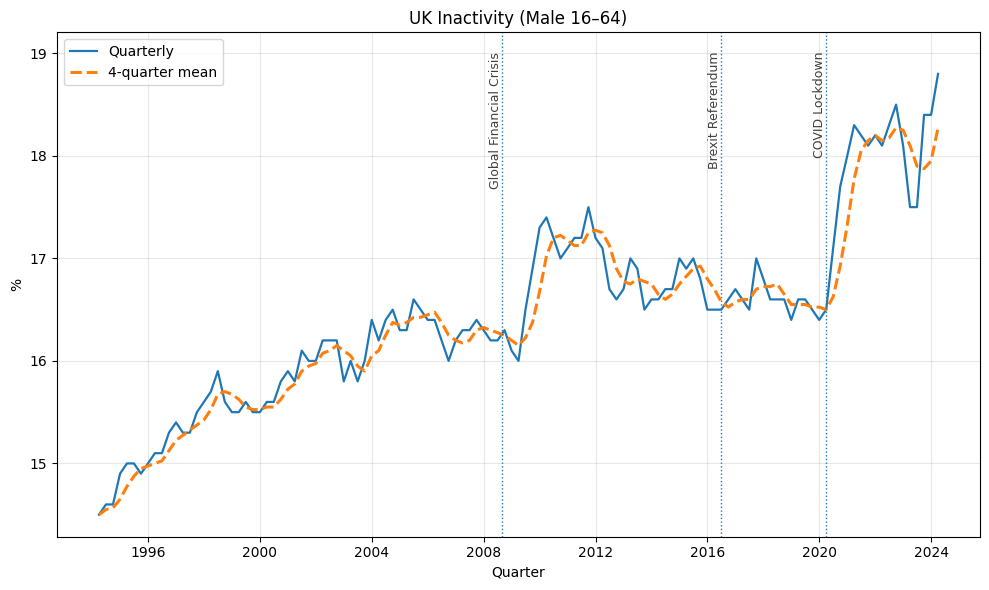

UK Inactivity (Male 16–64)
Start: 14.5%  →  End: 18.8%
~YoY change: +1.3%


In [6]:
# === Rolling mean + key events (Brexit, GFC, COVID) ===
import pandas as pd
import matplotlib.pyplot as plt

col_overall = "LFS: Economic Inactivity rate: UK: People: Aged 16-64: %: NSA"
col_female  = "LFS: Economic inactivity rate: UK: Female: Aged 16-64: %: SA"
col_male    = "LFS: Economic inactivity rate: UK: Male: Aged 16-64: %: SA"

EVENTS = [
    ("2008-09-01", "Global Financial Crisis"),
    ("2016-06-23", "Brexit Referendum"),
    ("2020-03-23", "COVID Lockdown"),
]

def plot_inactivity(
    column_name: str,
    title: str,
    rolling: int | None = 4,        # 4-quarter rolling mean; set None to disable
    show_events: bool = True,        # toggle vertical markers
):
    s = pd.to_numeric(df_lfs_q[column_name], errors="coerce").dropna()

    plt.figure(figsize=(10, 6))
    plt.plot(s.index, s.values, linewidth=1.6, label="Quarterly")

    if rolling and rolling > 1:
        s_roll = s.rolling(window=rolling, min_periods=1).mean()
        plt.plot(s_roll.index, s_roll.values, linestyle="--", linewidth=2.2,
                 label=f"{rolling}-quarter mean")

    if show_events:
        y_min, y_top = plt.ylim()
        plt.ylim(top=y_top * 1.01)

    for date_str, label in EVENTS:
        x = pd.to_datetime(date_str)
        plt.axvline(x, linestyle=":", linewidth=1)
        plt.text(x, y_top, label, rotation=90, va="top", ha="right", fontsize=9, alpha=0.75)

    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel("%")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Quick stats
    if len(s) > 0:
        print(f"{title}\nStart: {s.iloc[0]:.1f}%  →  End: {s.iloc[-1]:.1f}%")
        if len(s) > 5:
            yoy = s.iloc[-1] - s.iloc[-5]
            print(f"~YoY change: {yoy:+.1f}%")
    else:
        print(f"No valid data found for column: {column_name}")

plot_inactivity(col_overall, "UK Inactivity (People 16–64)")     # overall
plot_inactivity(col_female,  "UK Inactivity (Female 16–64)")     # female
plot_inactivity(col_male,    "UK Inactivity (Male 16–64)")       # male

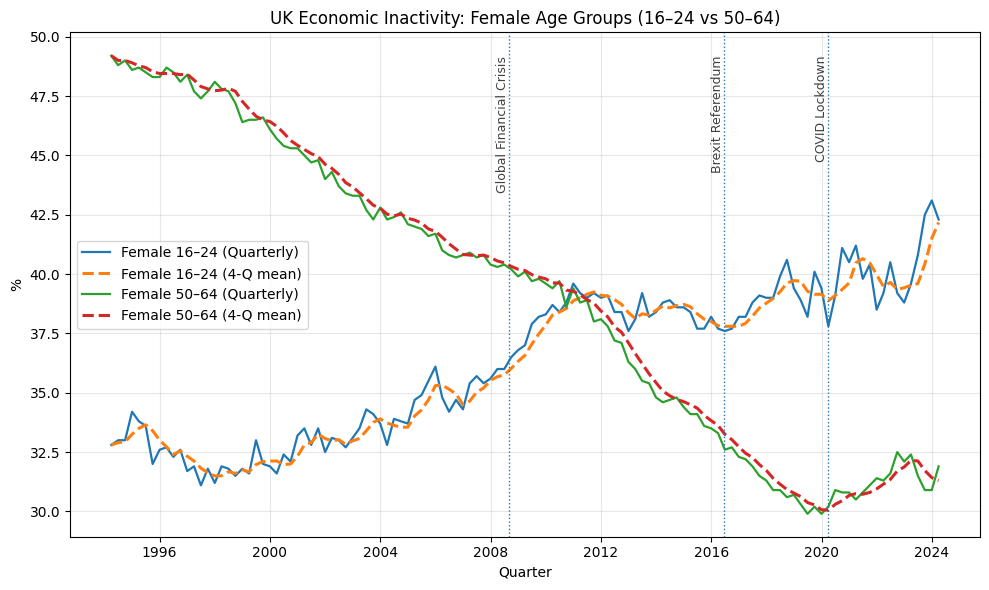

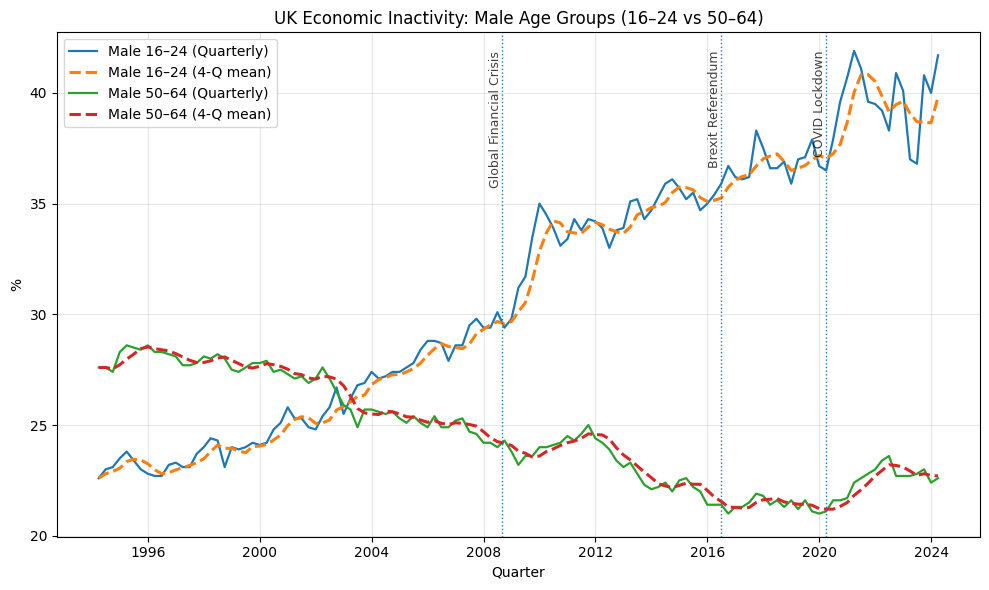

In [7]:
# === Age range analysis: young vs older, by gender ===

# --- Relevant column names  ---
col_female_16_24 = "LFS: Economic inactivity rate: Aged 16-24: UK: Female: %: SA"
col_female_50_64 = "LFS: Economic inactivity rate: UK: Female: Aged 50-64: %: SA"
col_female_25_49 = "LFS: Economic inactivity rate: UK: Female: Aged 25-49: %: SA"
col_male_25_49   = "LFS: Economic inactivity rate: UK: Male: Aged 25-49: %: SA"
col_male_16_24   = "LFS: Economic inactivity rate: Aged 16-24: UK: Male: %: SA"
col_male_50_64   = "LFS: Economic inactivity rate: UK: Male: Aged 50-64: %: SA"

EVENTS = [
    ("2008-09-01", "Global Financial Crisis"),
    ("2016-06-23", "Brexit Referendum"),
    ("2020-03-23", "COVID Lockdown"),
]

def plot_age_gender(columns: list[str], labels: list[str], title: str, rolling: int | None = 4):
    plt.figure(figsize=(10, 6))
    y_top = None

    for col, label in zip(columns, labels):
        s = pd.to_numeric(df_lfs_q[col], errors="coerce").dropna()
        plt.plot(s.index, s.values, linewidth=1.6, label=f"{label} (Quarterly)")
        if rolling and rolling > 1:
            s_roll = s.rolling(window=rolling, min_periods=1).mean()
            plt.plot(s_roll.index, s_roll.values, linestyle="--", linewidth=2.2, label=f"{label} ({rolling}-Q mean)")

        if y_top is None or s.max() > y_top:
            y_top = s.max()

    if y_top is not None:
        plt.ylim(top=y_top * 1.02)
        for date_str, label in EVENTS:
            x = pd.to_datetime(date_str)
            plt.axvline(x, linestyle=":", linewidth=1)
            plt.text(x, y_top, label, rotation=90, va="top", ha="right", fontsize=9, alpha=0.75)

    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel("%")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Run plots ---
plot_age_gender(
    [col_female_16_24, col_female_50_64],
    ["Female 16–24", "Female 50–64"],
    "UK Economic Inactivity: Female Age Groups (16–24 vs 50–64)"
)

plot_age_gender(
    [col_male_16_24, col_male_50_64],
    ["Male 16–24", "Male 50–64"],
    "UK Economic Inactivity: Male Age Groups (16–24 vs 50–64)"
)

In [8]:
# === Summary stats table for inactivity (thousands) ===
col_female_16_24_th = "LFS: Economically Inactive: UK: Female: Aged 16-24: Thousands: SA"
col_female_50_64_th = "LFS: Economically Inactive: UK: Female: Aged 50-64: Thousands: SA"
col_male_16_24_th   = "LFS: Economically Inactive: UK: Male: Aged 16-24: Thousands: SA"
col_male_50_64_th   = "LFS: Economically Inactive: UK: Male: Aged 50-64: Thousands: SA"

groups = {
    "Female 16–24": col_female_16_24_th,
    "Female 50–64": col_female_50_64_th,
    "Male 16–24":   col_male_16_24_th,
    "Male 50–64":   col_male_50_64_th,
}

def fmt_millions(x_thousands):
    return f"{x_thousands/1000:+.2f}M"  

def fmt_level_millions(x_thousands):
    return f"{x_thousands/1000:.2f}M"

rows_raw = []
rows_fmt = []

for label, col in groups.items():
    s = pd.to_numeric(df_lfs_q[col], errors="coerce").dropna()
    if s.empty:
        continue

    first_val = float(s.iloc[0])
    last_val  = float(s.iloc[-1])
    abs_chg   = last_val - first_val
    pct_chg   = (abs_chg / first_val) * 100 if first_val != 0 else float("nan")

    first_q = s.index[0]
    last_q  = s.index[-1]

    # Raw (thousands)
    rows_raw.append({
        "Group": label,
        "First (000s)": round(first_val, 1),
        "Last (000s)":  round(last_val, 1),
        "Abs change (000s)": round(abs_chg, 1),
        "Change (%)": round(pct_chg, 1),
        "First obs": first_q.strftime("%YQ%q") if hasattr(first_q, "strftime") else str(first_q),
        "Last obs":  last_q.strftime("%YQ%q")  if hasattr(last_q,  "strftime") else str(last_q),
    })

    # Formatted (millions)
    rows_fmt.append({
        "Group": label,
        "First":        fmt_level_millions(first_val),
        "Last":         fmt_level_millions(last_val),
        "Change (M)":   fmt_millions(abs_chg),
        "Change (%)":   f"{pct_chg:+.1f}%",
        "First obs":    first_q.strftime("%YQ%q") if hasattr(first_q, "strftime") else str(first_q),
        "Last obs":     last_q.strftime("%YQ%q")  if hasattr(last_q,  "strftime") else str(last_q),
    })

summary_thousands = pd.DataFrame(rows_raw)
summary_millions  = pd.DataFrame(rows_fmt)

def _abs_change_value(chg_str):
    # parse like "+0.39M" -> 0.39
    try:
        return abs(float(chg_str.replace("M","")))
    except Exception:
        return float("nan")

summary_millions_sorted = summary_millions.copy()
summary_millions_sorted["__abs__"] = summary_millions_sorted["Change (M)"].apply(_abs_change_value)
summary_millions_sorted = summary_millions_sorted.sort_values("__abs__", ascending=False).drop(columns="__abs__").reset_index(drop=True)

summary_millions_sorted

,Group,First,Last,Change (M),Change (%),First obs,Last obs
0,Male 16–24,0.76M,1.51M,+0.75M,+98.0%,1994Qq,2024Qq
1,Female 16–24,1.09M,1.49M,+0.39M,+36.0%,1994Qq,2024Qq
2,Male 50–64,1.22M,1.46M,+0.24M,+20.0%,1994Qq,2024Qq
3,Female 50–64,2.24M,2.16M,-0.08M,-3.6%,1994Qq,2024Qq


In [9]:

# --- Helper ---
def get_col(df: pd.DataFrame, exact: str) -> pd.Series:
    if exact in df.columns:
        return pd.to_numeric(df[exact], errors="coerce")
    cand = [c for c in df.columns if all(w.lower() in c.lower() for w in re.split(r"[: ]+", exact) if w)]
    print(f"[WARN] Column not found:\n  {exact}\n  Close matches:\n    - " + "\n    - ".join(cand[:5]))
    raise KeyError(exact)

# --- Your chosen columns (rates % and counts 000s) ---
COLS_RATE = {
    ("Female","16-24"): "LFS: Economic inactivity rate: Aged 16-24: UK: Female: %: SA",
    ("Female","50-64"): "LFS: Economic inactivity rate: UK: Female: Aged 50-64: %: SA",
    ("Male","16-24"):   "LFS: Economic inactivity rate: Aged 16-24: UK: Male: %: SA",
    ("Male","50-64"):   "LFS: Economic inactivity rate: UK: Male: Aged 50-64: %: SA",
    ("All","16-64"):    "LFS: Economic Inactivity rate: UK: People: Aged 16-64: %: NSA",
}

COLS_LVL = {
    ("Female","16-24"): "LFS: Economically Inactive: UK: Female: Aged 16-24: Thousands: SA",
    ("Female","50-64"): "LFS: Economically Inactive: UK: Female: Aged 50-64: Thousands: SA",
    ("Male","16-24"):   "LFS: Economically Inactive: UK: Male: Aged 16-24: Thousands: SA",
    ("Male","50-64"):   "LFS: Economically Inactive: UK: Male: Aged 50-64: Thousands: SA",
    ("All","16-64"): "LFS: Economically Inactive: UK: All: Aged 16-64: Thousands: SA"
}


records = []
for (sex, age), colname in COLS_RATE.items():
    s_rate = get_col(df_lfs_q, colname).dropna()
    s_lvl  = get_col(df_lfs_q, COLS_LVL[(sex, age)]).reindex(s_rate.index).astype(float)
    df_tmp = pd.DataFrame({
        "date": s_rate.index,
        "sex": sex,
        "age": age,
        "rate_pct": s_rate.values,
        "level_th": s_lvl.values    # thousands
    })
    records.append(df_tmp)

tidy = pd.concat(records, ignore_index=True).sort_values("date")
tidy["level_mn"] = tidy["level_th"] / 1000.0   # millions
tidy.head(20)

,date,sex,age,rate_pct,level_th,level_mn
0,1994-03-31,Female,16-24,32.8,1093.0,1.093
484,1994-03-31,All,16-64,24.0,8580.0,8.580
121,1994-03-31,Female,50-64,49.2,2236.0,2.236
242,1994-03-31,Male,16-24,22.6,764.0,0.764
363,1994-03-31,Male,50-64,27.6,1218.0,1.218
1,1994-06-30,Female,16-24,33.0,1091.0,1.091
122,1994-06-30,Female,50-64,48.8,2225.0,2.225
485,1994-06-30,All,16-64,24.0,8626.0,8.626
243,1994-06-30,Male,16-24,23.0,769.0,0.769
364,1994-06-30,Male,50-64,27.6,1220.0,1.220


In [10]:
def qlabel(ts):
    # ts is a pandas Timestamp (quarter end) from index
    return f"{ts.year}Q{((ts.month - 1)//3) + 1}"

BASE = pd.Timestamp("2019-12-31")  # 2019 Q4. Change this if needed.
LATEST = tidy["date"].max()
YOY = LATEST - pd.offsets.QuarterEnd(4)

def nearest_quarter_date(series, target):
    return series[series<=target].max()

base_date  = nearest_quarter_date(tidy["date"].unique(), BASE)
yoy_date   = nearest_quarter_date(tidy["date"].unique(), YOY)
latest_date = LATEST

def summarize(group_label):
    sex, age = group_label
    g = tidy[(tidy.sex==sex) & (tidy.age==age)]
    g = g.set_index("date").sort_index()

    b = g.loc[base_date]
    y = g.loc[yoy_date]
    l = g.loc[latest_date]

    out = {
        "Group": f"{sex} {age}",
        "Baseline": qlabel(base_date),       
        "Latest":   qlabel(latest_date), 
        "Level (M) – baseline": round(b["level_mn"], 2),
        "Level (M) – latest":   round(l["level_mn"], 2),
        "Δ since baseline (M)":  round(l["level_mn"] - b["level_mn"], 2),
        "YoY Δ (M)":            round(l["level_mn"] - y["level_mn"], 2),
        "Rate – baseline (%)":  round(b["rate_pct"], 1),
        "Rate – latest (%)":    round(l["rate_pct"], 1),
        "Rate YoY Δ (pp)":      round(l["rate_pct"] - y["rate_pct"], 1),
    }
    return out

groups = [("Female","16-24"), ("Female","50-64"), ("Male","16-24"), ("Male","50-64")]
summary = pd.DataFrame([summarize(g) for g in groups]).sort_values("Δ since baseline (M)", ascending=False).reset_index(drop=True)
summary

,Group,Baseline,Latest,Level (M) – baseline,Level (M) – latest,Δ since baseline (M),YoY Δ (M),Rate – baseline (%),Rate – latest (%),Rate YoY Δ (pp)
0,Male 16-24,2019Q4,2024Q1,1.29,1.51,0.22,0.19,36.7,41.7,4.7
1,Female 50-64,2019Q4,2024Q1,1.96,2.16,0.20,-0.03,29.9,31.9,-0.5
2,Female 16-24,2019Q4,2024Q1,1.33,1.49,0.16,0.11,39.4,42.3,2.7
3,Male 50-64,2019Q4,2024Q1,1.32,1.46,0.14,-0.00,21.0,22.6,-0.1


<Figure size 800x500 with 0 Axes>

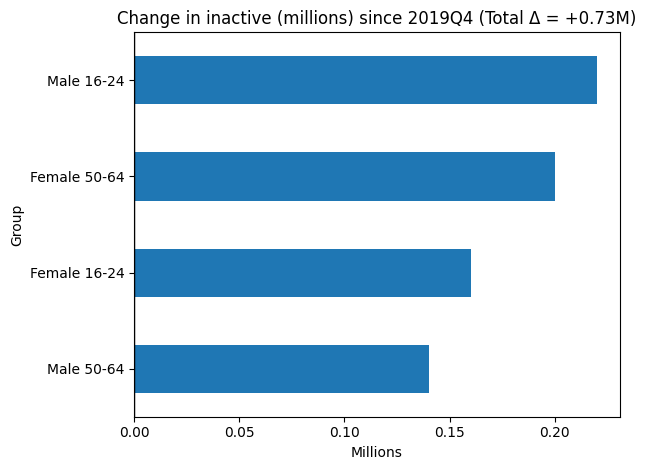

In [11]:
# Compute total inactivity (people 16-64) change since baseline (levels)
all_base   = tidy[(tidy.sex=="All") & (tidy.age=="16-64")].set_index("date").loc[base_date, "level_mn"]
all_latest = tidy[(tidy.sex=="All") & (tidy.age=="16-64")].set_index("date").loc[latest_date, "level_mn"]
total_delta = round(all_latest - all_base, 2)

# Group deltas
deltas = summary[["Group","Δ since baseline (M)"]].set_index("Group").sort_values("Δ since baseline (M)")
plt.figure(figsize=(8,5))
deltas.plot(kind="barh", legend=False)
plt.axvline(0, color="k", linewidth=1)
plt.title(f"Change in inactive (millions) since {qlabel(base_date)} (Total Δ = {total_delta:+.2f}M)")
plt.xlabel("Millions")
plt.tight_layout()
plt.show()

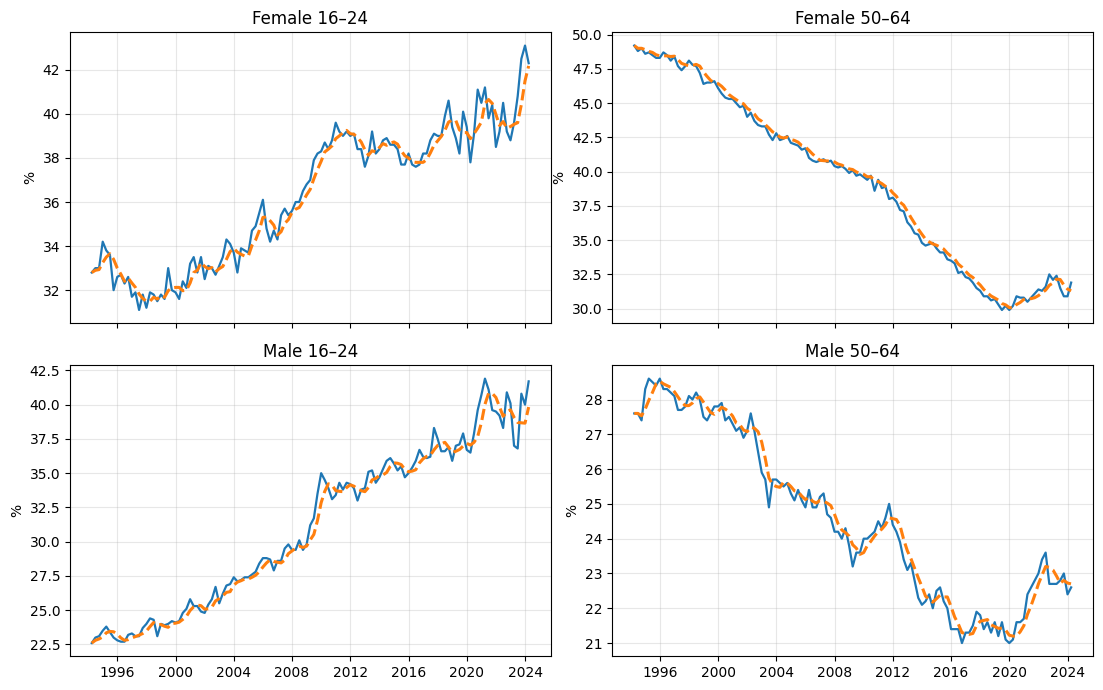

In [12]:
fig, axes = plt.subplots(2,2, figsize=(11,7), sharex=True)
axes = axes.ravel()
titles = ["Female 16–24","Female 50–64","Male 16–24","Male 50–64"]

for ax, (sex, age), ttl in zip(axes, groups, titles):
    g = tidy[(tidy.sex==sex) & (tidy.age==age)].set_index("date").sort_index()
    ax.plot(g.index, g["rate_pct"], lw=1.6)
    ax.plot(g.index, g["rate_pct"].rolling(4, min_periods=1).mean(), lw=2.2, ls="--")
    ax.set_title(ttl); ax.set_ylabel("%"); ax.grid(alpha=0.3)

plt.tight_layout(); plt.show()

# Optional API Call for thematic Analysis of Survey Response

This notebook is set up for you to enter an OPEN_AI API key if running in Colabs OR 
If running locally set via .env OPENAI_API_KEY=XYZ

 **if you do not have an OpenAI key, please refer to report for description of manual thematic analysis and example  api call results**

In [13]:
import os, getpass
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY") or getpass.getpass("Enter OPENAI_API_KEY: ")

In [14]:
# Set up OpenAI client 
try:
    from openai import OpenAI
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "openai"])
    from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)
print("Client ready")

Client ready


In [15]:
# Load qual_survey_responses
df = dfs["qual_survey_responses.csv"]
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(3)

Shape: (110, 4)
Columns: ['Participant ID', 'Employment Status', 'UK Region', 'Response']


,Participant ID,Employment Status,UK Region,Response
0,P001,Unemployed,Scotland,The government should focus on providing more ...
1,P002,Employed,North West,I believe the government should create more in...
2,P003,Self-employed,London,The government needs to address the root cause...


In [16]:
import json
import textwrap
#  configuration 
MODEL = "gpt-5-mini"
TEXT_COL = "Response"

SYSTEM_PROMPT = """
You are an expert Social Science Researcher performing a rigorous, inductive thematic analysis based on the principles of Braun & Clarke. Your task is to analyse the following collection of survey responses to identify the general, overarching themes present across the entire dataset.

A theme is a patterned response or meaning found across multiple responses, not just a summary of one. Your analysis must be grounded exclusively in the provided text.

Your entire output must be a single, valid JSON object that adheres to the required structure.
"""

JSON_SCHEMA = {
    "type": "object",
    "properties": {
        "analysis_summary": {
            "type": "string",
            "description": "A one-paragraph synthesis of the key findings and dominant themes from the entire set of responses."
        },
        "themes": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "theme_label": {"type": "string", "description": "A concise, 3-5 word name for the theme."},
                    "definition": {"type": "string", "description": "A one-sentence explanation of the theme's central concept."},
                    "interpretation": {"type": "string", "description": "Analysis of why this theme is significant and what it implies."},
                    "representative_quotes": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "2-3 verbatim quotes from different responses that strongly illustrate this theme."
                    }
                },
                "required": ["theme_label", "definition", "interpretation", "representative_quotes"]
            }
        }
    },
    "required": ["analysis_summary", "themes"]
}


# --- THE API CALL ---

# Combine all survey responses into a single string.
all_responses_text = "\n---\n".join(df[TEXT_COL].dropna().astype(str))

print(f"📞 Sending {len(df)} responses to '{MODEL}' for analysis...")

try:
    resp = client.chat.completions.create(
        model=MODEL,
        response_format={"type": "json_schema", "json_schema": {"name": "holistic_thematic_analysis", "schema": JSON_SCHEMA}},
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": all_responses_text}
        ],
    )

    analysis_result = json.loads(resp.choices[0].message.content)

    # --- PRINT THE RESULTS ---
    print("\n Analysis Complete!\n")
    print("="*30)
    print("   OVERALL ANALYSIS SUMMARY")
    print("="*30)
    summary = analysis_result.get('analysis_summary', 'Not found.')
    print(textwrap.fill(summary, width=80))

    print("\n" + "="*30)
    print("      IDENTIFIED THEMES")
    print("="*30)
    for i, theme in enumerate(analysis_result.get('themes', []), 1):
        print(f"\nTHEME {i}: {theme.get('theme_label', 'No Label').upper()}")
        print("-" * 25)
        print(f"  Definition: {theme.get('definition', 'N/A')}")
        print(f"  Interpretation: {theme.get('interpretation', 'N/A')}")
        print("  Supporting Quotes:")
        for quote in theme.get('representative_quotes', []):
            print(f'    > "{quote}"')

except Exception as e:
    print(f"\n An error occurred: {e}")

📞 Sending 110 responses to 'gpt-5-mini' for analysis...

 Analysis Complete!

   OVERALL ANALYSIS SUMMARY
Responses coalesce around two broad policy approaches: (1) active labour-market
interventions—training, retraining and targeted upskilling (from school through
adult learning and apprenticeships) closely linked to employer engagement—and
(2) strengthening social and structural supports that remove barriers to work
(mental and physical health services, childcare, transport, housing, and
protections for vulnerable groups). Complementary themes include calls for
public investment and job-creation (infrastructure, green projects, public-
sector roles), measures to improve job quality and income security (minimum pay,
predictable schedules, protections for gig and zero-hours workers), and actions
to manage technological change (automation, AI and digital skills). Many
respondents argue for a mixed strategy combining incentives for employers,
streamlined support for the self-employed, an